In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from pywaffle import Waffle
from wordcloud import WordCloud
import joblib


In [2]:
# Đọc data
df = pd.read_csv('Cleaned-Data.csv')

# Lọc chỉ China
df = df[df['Country'] == 'China']

# Tạo cột target Is_Infected
df['Is_Infected'] = (
    (df['Contact_Yes'] == 1) &
    ((df['Severity_Mild'] == 1) | (df['Severity_Moderate'] == 1) | (df['Severity_Severe'] == 1))
).astype(int)

# Kiểm tra số mẫu
print(f"Số mẫu tại China: {df.shape[0]}")
print(f"Số người bị nhiễm (Is_Infected=1): {df['Is_Infected'].sum()}")


Số mẫu tại China: 31680
Số người bị nhiễm (Is_Infected=1): 7920


In [3]:
display("Peeking into Data", df)

'Peeking into Data'

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes,Country,Is_Infected
0,1,1,1,1,1,0,1,1,1,1,...,0,1,0,0,0,0,0,1,China,1
1,1,1,1,1,1,0,1,1,1,1,...,0,1,0,0,0,0,1,0,China,0
2,1,1,1,1,1,0,1,1,1,1,...,0,1,0,0,0,1,0,0,China,0
3,1,1,1,1,1,0,1,1,1,1,...,0,0,1,0,0,0,0,1,China,1
4,1,1,1,1,1,0,1,1,1,1,...,0,0,1,0,0,0,1,0,China,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31675,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,China,0
31676,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,1,0,0,China,0
31677,0,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,China,0
31678,0,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,China,0


In [4]:
symptom_columns = [
    'Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat',
    'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea', 'None_Experiencing'
]

age_columns = ['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']

gender_columns = ['Gender_Female', 'Gender_Male', 'Gender_Transgender']

severity_columns = ['Severity_Mild', 'Severity_Moderate', 'Severity_None', 'Severity_Severe']

contact_columns = ['Contact_Dont-Know', 'Contact_No', 'Contact_Yes']
symptom_columns = [
    'Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat',
    'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea', 'None_Experiencing'
]

age_columns = ['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']

gender_columns = ['Gender_Female', 'Gender_Male', 'Gender_Transgender']

severity_columns = ['Severity_Mild', 'Severity_Moderate', 'Severity_None', 'Severity_Severe']

contact_columns = ['Contact_Dont-Know', 'Contact_No', 'Contact_Yes']

columns_to_exclude = ['Severity_Moderate', 'Severity_Severe', 'Severity_None']



In [5]:
def get_symptom_counts(df):
    symptom_columns = [
        'Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat',
        'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea', 'None_Experiencing'
    ]

    # Kiểm tra cột có trong df hay không (đề phòng trường hợp thiếu cột)
    available_symptom_columns = [col for col in symptom_columns if col in df.columns]

    # Tính tổng số người có triệu chứng (tổng số giá trị = 1 cho từng cột)
    symptom_counts = df[available_symptom_columns].sum().sort_values(ascending=False)

    return symptom_counts

In [6]:
# Các cột
target_column = 'Is_Infected'
features_to_exclude_from_numerical = [target_column, 'Country']
numerical_features = [
    col for col in df.columns 
    if col not in features_to_exclude_from_numerical + columns_to_exclude
]
categorical_features = ['Country']

# Tách X, y
X = df.drop(target_column, axis=1)
y = df[target_column]

# Tách train/test (vẫn đúng)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.7, random_state=42
)

# Tạo preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

rf = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
# Tạo pipeline hoàn chỉnh
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(
        max_depth=10,
        min_samples_split=2,
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ))
])

# Fit & predict
rf_pipeline.fit(X_train, y_train)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

# Giảm ngưỡng để tăng recall
threshold = 0.4
y_pred_thresh = (y_proba >= threshold).astype(int)


# Đánh giá kết quả
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_thresh))

# In confusion matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_thresh))

# In AUC score
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc:.4f}")


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     16632
           1       0.75      1.00      0.86      5544

    accuracy                           0.92     22176
   macro avg       0.87      0.94      0.90     22176
weighted avg       0.94      0.92      0.92     22176

=== Confusion Matrix ===
[[14769  1863]
 [    0  5544]]
ROC AUC Score: 0.9528


In [7]:
full_df_for_prediction = df.copy()

# Dự đoán với RF
full_df_for_prediction['Predicted_Is_Infected_RF'] = rf_pipeline.predict(full_df_for_prediction.drop(target_column, axis=1))


In [8]:
symptom_counts = get_symptom_counts(full_df_for_prediction)
total = symptom_counts.sum()
symptom_percent = (symptom_counts / total * 100).round().astype(int)


--- Tỷ lệ % người mắc COVID dự đoán (China, Random Forest) ---
Tổng số mẫu: 31680
Số người dự đoán nhiễm: 10560
Tỷ lệ nhiễm dự đoán: 33.33%


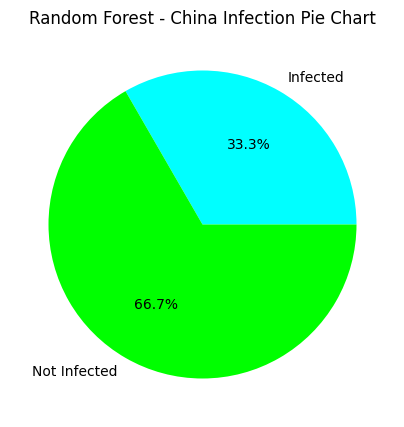

In [9]:
print("\n--- Tỷ lệ % người mắc COVID dự đoán (China, Random Forest) ---")

total_population = full_df_for_prediction.shape[0]
predicted_infected = full_df_for_prediction['Predicted_Is_Infected_RF'].sum()
percentage_infected = (predicted_infected / total_population) * 100

print(f"Tổng số mẫu: {total_population}")
print(f"Số người dự đoán nhiễm: {predicted_infected}")
print(f"Tỷ lệ nhiễm dự đoán: {percentage_infected:.2f}%")

# Vẽ Pie chart
plt.figure(figsize=(5,5))
plt.pie([predicted_infected, total_population - predicted_infected],
        labels=['Infected', 'Not Infected'],
        autopct='%1.1f%%', colors=['aqua', 'lime'])
plt.title("Random Forest - China Infection Pie Chart")
plt.show()


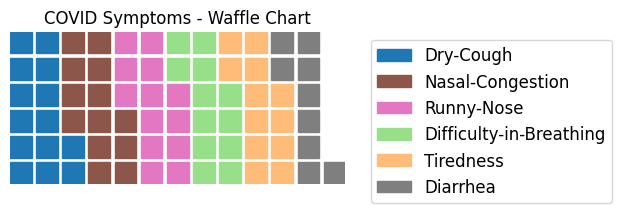

In [10]:
top_symptoms = symptom_percent.head(6)

# Waffle Chart
fig = plt.figure(
    FigureClass=Waffle,
    rows=6,
    values=top_symptoms.to_dict(),
    colors=['#1f77b4', '#8c564b', '#e377c2', '#98df8a', '#ffbb78', '#7f7f7f'],
    title={'label': 'COVID Symptoms - Waffle Chart', 'loc': 'center'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'ncol': 1, 'fontsize': 12}
)
plt.show()

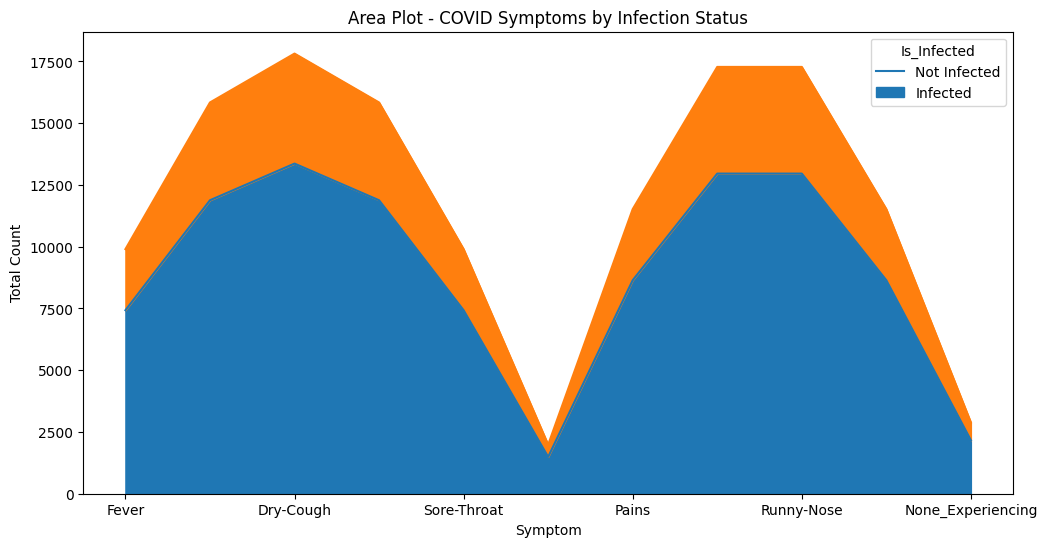

In [11]:
symptom_by_infection = full_df_for_prediction.groupby('Is_Infected')[symptom_columns].sum()

# Plot
symptom_by_infection.T.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Area Plot - COVID Symptoms by Infection Status')
plt.xlabel('Symptom')
plt.ylabel('Total Count')
plt.legend(title='Is_Infected', labels=['Not Infected', 'Infected'])
plt.show()

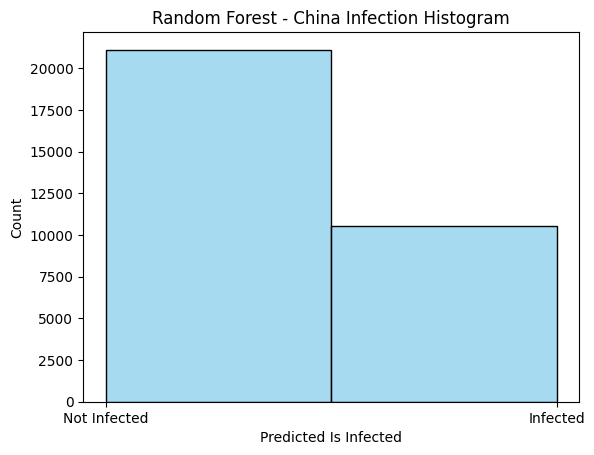

In [12]:
sns.histplot(full_df_for_prediction['Predicted_Is_Infected_RF'], bins=2, color='skyblue')
plt.title('Random Forest - China Infection Histogram')
plt.xlabel('Predicted Is Infected')
plt.ylabel('Count')
plt.xticks([0,1], ['Not Infected', 'Infected'])
plt.show()

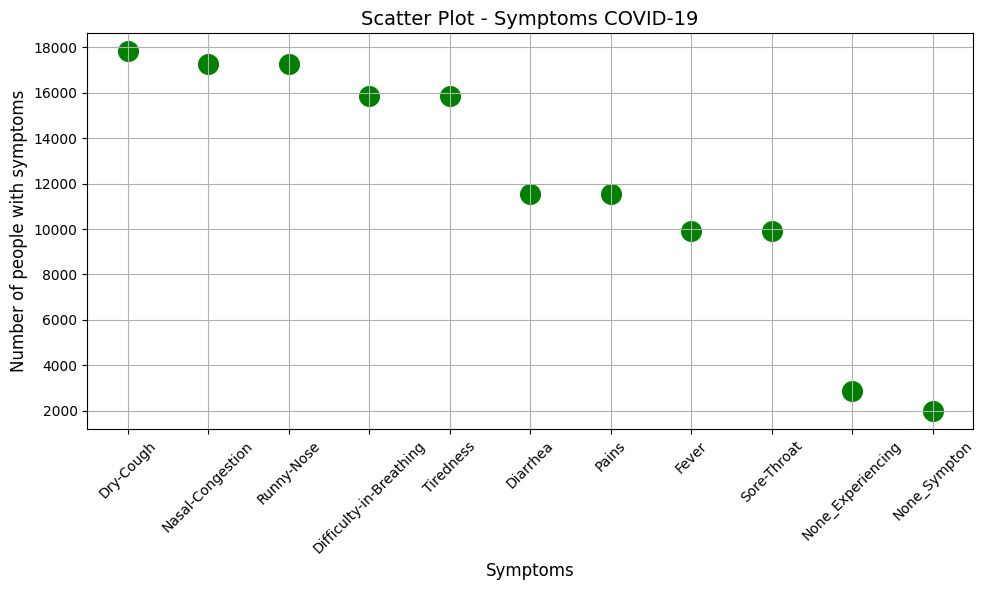

In [13]:
symptom_counts = get_symptom_counts(full_df_for_prediction)

# Vẽ scatter plot cho các triệu chứng
plt.figure(figsize=(10, 6))
plt.scatter(symptom_counts.index, symptom_counts.values, color='green', s=200)
plt.title('Scatter Plot - Symptoms COVID-19', fontsize=14)
plt.xlabel('Symptoms', fontsize=12)
plt.ylabel('Number of people with symptoms', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

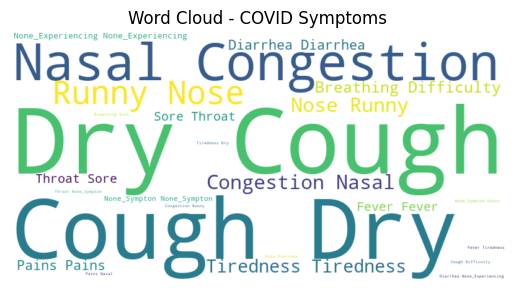

In [14]:
symptom_counts = full_df_for_prediction[symptom_columns].sum()

# Ghép thành text để tạo wordcloud
symptom_text = ' '.join([((symptom + ' ') * int(count)) for symptom, count in symptom_counts.items()])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(symptom_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - COVID Symptoms')
plt.show()

In [15]:
# Giả sử mở rộng không lọc China
df_full = pd.read_csv('Cleaned-Data.csv')
df_full['Is_Infected'] = (
    (df_full['Contact_Yes'] == 1) &
    ((df_full['Severity_Mild'] == 1) | (df_full['Severity_Moderate'] == 1) | (df_full['Severity_Severe'] == 1))
).astype(int)

choropleth_df = df_full.groupby('Country')['Is_Infected'].sum().reset_index()

fig = px.choropleth(choropleth_df,
                    locations='Country',
                    locationmode='country names',
                    color='Is_Infected',
                    color_continuous_scale='Reds',
                    title='COVID-19 Infection Choropleth Map')
fig.show()

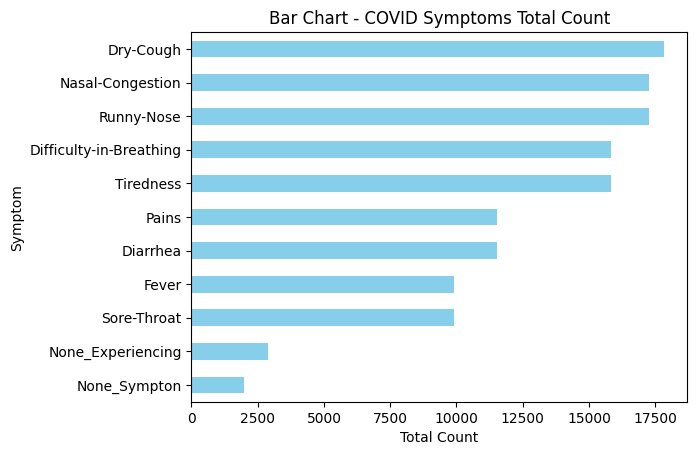

In [16]:
symptom_counts.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Bar Chart - COVID Symptoms Total Count')
plt.xlabel('Total Count')
plt.ylabel('Symptom')
plt.show()

In [17]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Bước 2: Tạo Pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Bước 3: Huấn luyện mô hình
model.fit(X_train, y_train)

# Bước 4: Lưu toàn bộ pipeline vào model.pkl
joblib.dump(model, 'model.pkl')

['model.pkl']